In [1]:
from skimage.feature import hog
from skimage import io,color
from skimage.transform import resize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
import os
from  LBP_descriptor import LocalBinaryPatterns
import commonfunctions as cf
import cv2
# import pandas as pd
import csv
from skimage.feature import greycomatrix, greycoprops
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import timeit



# Get our training data 
X_train: features of training data.\
Y_train: labels of training data (1-->F, 0--> M).


In [2]:

# ICDAR LABELS 
labels_ICDAR=[]
with open("our dataset/train_answers.csv", 'r') as file:
    csvreader = csv.reader(file, delimiter=',')
    rows= np.array(list(csvreader))[1:].astype(float).astype(int)
for row in rows:
    labels_ICDAR.append(row[1])
    
def get_label_ICDAR(img):
    if img[0]=='0':
        if img[1]=='0': 
            return labels_ICDAR[int(img[2])-1]
        else: 
            return labels_ICDAR[int(img[1:3])-1]
    else: 
         return labels_ICDAR[int(img[0:3])-1]
        
def get_label_evaluation_test():
    truth = None
    with open('ground_truth.txt', 'rb') as gt_file:
        truth = [ int(line)  for line in gt_file.readlines()]
        truth = np.array(truth)
    return truth

def read_labels(path): 
    y=[]
    files = os.listdir(path)

    for file in files:
        if file[0]=='F':
            y.append(0)
        elif file[0]=='M':
            y.append(1)
        elif '_' in file: # ICDAR dataset
            y.append(get_label_ICDAR(file[1:4]))
        else : # Evaluation test
            y = get_label_evaluation_test()
            return y
    y=np.array(y).astype(float)
    return y 

Y_train= read_labels("Training_data/")
# Y_test= read_labels("Test_data/")
Y_evaluation_test= read_labels("test/")

# HOG feature

In [4]:
def HOG(img):
    img = np.array(resize(img,(128,64))) 
    feature_vector, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3), visualize=True)
    return feature_vector,hog_image


# LBP feature and histogram descriptor

In [5]:
# create object from LBP class to use it as our descriptor
# takes 2 parameters: number of data (train + test ) and number of neighbors
desc = LocalBinaryPatterns(24, 8)

# GLCM feature

In [6]:
def GLCM (image):

    # convert image to gray
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    featureVector=[]

    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
    featureVector.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    featureVector.append(greycoprops(glcm, 'correlation')[0, 0])
    featureVector.append(greycoprops(glcm, 'contrast')[0, 0])
    featureVector.append(greycoprops(glcm, 'homogeneity')[0, 0])
    return featureVector

# Training data: feature Extraction 

In [8]:
#  NOTE => to save your time: 
#  Run this cell once and the features will be saved in external file so that you can read them by running the next cell.
X_train=[]
HOG_train=[]
LBP_train=[]
GLCM_train=[]
files = os.listdir("Training_data/")
i=0
for file in files:
    # read the image
    img = io.imread("Training_data/"+file )

    # ------------------- HOG feature------------------------
    feature_vector,hog_image=HOG(img)
    # --------------------------------------------------------
    HOG_train.append(feature_vector)
    
    #------------------- LBP feature------------------------
    img = cf.downSize(img , 0.5)
    hist = desc.describe(img)
    LBP_train.append(hist)
    #--------------------------------------------------------

    #------------------- GLCM feature------------------------
    img = cv2.imread("Training_data/"+file )  
    GLCM_train=GLCM(img)
    #--------------------------------------------------------
    
    # concatenate all the features in X_train   
    feature_vector_temp=np.hstack((HOG_train,LBP_train)).tolist()
    feature_vector_temp2=np.hstack((feature_vector_temp[0],GLCM_train)).tolist()
    X_train.append(feature_vector_temp2)
    # reset them for the next img
    HOG_train=[]
    LBP_train=[]
    GLCM_train=[]
    
#convert to numpy array
#X_train=np.array(X_train)

#write feature vector of each image in external file
with open('training_features.npy', 'wb') as f:
    np.save(f, X_train)
f.close()  
   

c:\Python310\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation

In [3]:
# Read feature vector of train data from the npy file 
with open('training_features.npy', 'rb') as f:
    X_train = np.load(f,allow_pickle=True)
f.close() 

#  Test data: feature Extraction
 

c:\Python310\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation

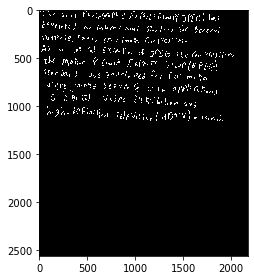

In [12]:
# NOTE => to save your time: 
# Run this cell once and the features will be saved in external files so that you can read them by running the next cell.
X_test=[]
HOG_test=[]
LBP_test=[]
GLCM_test=[]
# files = os.listdir("Test_data/")
files = os.listdir("Test_data_evaluation/")

for file in files:
   
    # read te img
    # img = io.imread("Test_data/" +file )
    img = io.imread("Test_data_evaluation/" +file )
        
    #------------------- HOG feature------------------------
    feature_vector,hog_image=HOG(img)
    HOG_test.append(feature_vector)
    #--------------------------------------------------------

    # #------------------- LBP feature------------------------
    img = cf.downSize(img , 0.5)
    hist = desc.describe(img)
    LBP_test.append(hist)
    #--------------------------------------------------------

    #------------------- GLCM feature------------------------
    # img = cv2.imread("Test_data/"+file )  
    img = cv2.imread("Test_data_evaluation/"+file )  
    GLCM_test=GLCM(img)
    #--------------------------------------------------------

    # concatenate all the features in X_train
    feature_test_temp=(np.hstack((HOG_test,LBP_test))).tolist()
    feature_test_temp2=(np.hstack((feature_test_temp[0],GLCM_test))).tolist()
    X_test.append( feature_test_temp2 )

    # reset them for the next image
    HOG_test=[]
    LBP_test=[]
    GLCM_test=[]

    
#X_test=np.array(X_test)

#write feature vector of test data in external file
# with open('test_features.npy', 'wb') as f:
with open('test_evaluation_features.npy', 'wb') as f:
    np.save(f, X_test)
f.close()    

In [4]:
# Read feature vector of test data from the npy file 
with open('test_evaluation_features.npy', 'rb') as f:
# with open('test_features.npy', 'rb') as f:
    X_test = np.load(f ,allow_pickle=True)
f.close()  

# Assign weights for each feature

In [ ]:
# # initialize array of ones for initial weights
# w= np.ones(206)
# #----------- feature vector partitions -------------------
# # HOG : 0 => 10800
# # LBP : 10800 => 11060
# #---------------------------------------

# # update weights of each feature
# w[0: 10800 ] = 2
# w[ 10800: 11060 ] = 0.5

# # length of weights should be the same as number of points??!
# print(len(w))
# #print(len(X_train[0]))


# Classification:

# 1. Random forest classifier

In [ ]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train,Y_train)
Y_Predicted=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")

In [6]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=1000)

In [11]:
if not os.path.exists("C:/Users/Pc/CMP3_sem2_Pattern Recognition project/Handwriting-detection/out"):
    os.makedirs("C:/Users/Pc/CMP3_sem2_Pattern Recognition project/Handwriting-detection/out")

file1 = open('C:/Users/Pc/CMP3_sem2_Pattern Recognition project/Handwriting-detection/out/results.txt', 'a')
file1.truncate(0)

file2 = open('C:/Users/Pc/CMP3_sem2_Pattern Recognition project/Handwriting-detection/out/times.txt', 'a')
file2.truncate(0)

i = 1
for singleImage in X_test:
    start = timeit.default_timer() 
    Y_Predicted=clf.predict([singleImage])
    end= timeit.default_timer()  - start

    value = Y_Predicted
    # if (Y_Predicted != Y_evaluation_test[i-1]):
    #     value = -1
    # end = 0
    if(end == 0):
        end =  0.001
    if( i == len(X_test)):
        file1.write(str(int(value)))
        file2.write(str(round(end,2)))
    else:
        file1.write(str(int(value))+ "\n")
        file2.write(str(round(end,2))+ "\n")
    i+=1
     
file1.close() 
file2.close() 
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")

# 2. Linear SVM classifier

In [ ]:
clf=LinearSVC(C=300.0)
clf.fit(X_train,Y_train )
Y_Predicted=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")
print("Accuracy:",metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100,"%")


In [ ]:
clf=svm.SVC(C=300.0)
clf.fit(X_train,Y_train )
Y_Predicted=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")
print("Accuracy:",metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100,"%")


# 3. Adaboost classifier

In [ ]:
clf=AdaBoostClassifier(n_estimators=400)
clf.fit(X_train,Y_train)
Y_Predicted=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")
print("Accuracy:",metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100,"%")


# 4. KNN classifier

In [ ]:
accuracies=[]
for k in range(1,50):
    clf=KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train,Y_train)
    Y_Predicted=clf.predict(X_test)
    # accuracies.append(metrics.accuracy_score(Y_test, Y_Predicted)*100)
    accuracies.append(metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100)


print("Accuracy:",accuracies[np.argmax(accuracies)],"%")

# 5. Gradient Boosting classifier

In [ ]:
clf=GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=8,random_state=0)
clf.fit(X_train,Y_train)
Y_Predicted=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")
print("Accuracy:",metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100,"%")

# 6. MLP classifier

In [ ]:
clf= MLPClassifier(random_state=0, max_iter=100, hidden_layer_sizes=2)
clf.fit(X_train,Y_train)
Y_Predicted=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(Y_test, Y_Predicted)*100,"%")
print("Accuracy:",metrics.accuracy_score(Y_evaluation_test, Y_Predicted)*100,"%")
